# Random Forest Baseline
## Imports

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

## Dataloading

In [12]:
# --- Load Data ---
train_categorical = pd.read_excel("./data/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
train_quantitative = pd.read_excel("./data/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
solutions = pd.read_excel("./data/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

## Preprocessing

In [13]:
# --- Merge Datasets ---
merged_df = pd.merge(train_categorical, train_quantitative, on="participant_id", how="inner")
merged_df = pd.merge(merged_df, solutions, on="participant_id", how="inner")

# --- Prepare Features and Labels ---
X = merged_df.drop(columns=["participant_id", "ADHD_Outcome", "Sex_F"])
y = merged_df["ADHD_Outcome"]

# --- Encode Categorical Columns ---
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include='object').columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))

# --- Impute Missing Values and Scale ---
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
X_processed = pipeline.fit_transform(X_encoded)

## Training

In [14]:

# --- Train Random Forest ---
best_rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    bootstrap=True,
    random_state=42
)

# --- Cross-validation ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_scores = []
y_preds = []
y_vals = []

for train_idx, val_idx in skf.split(X_processed, y):
    X_train, X_val = X_processed[train_idx], X_processed[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    best_rf.fit(X_train, y_train)
    y_pred = best_rf.predict(X_val)

    rf_scores.append(f1_score(y_val, y_pred))
    y_preds.extend(y_pred)
    y_vals.extend(y_val)

## Metrics
#### F1 Scores

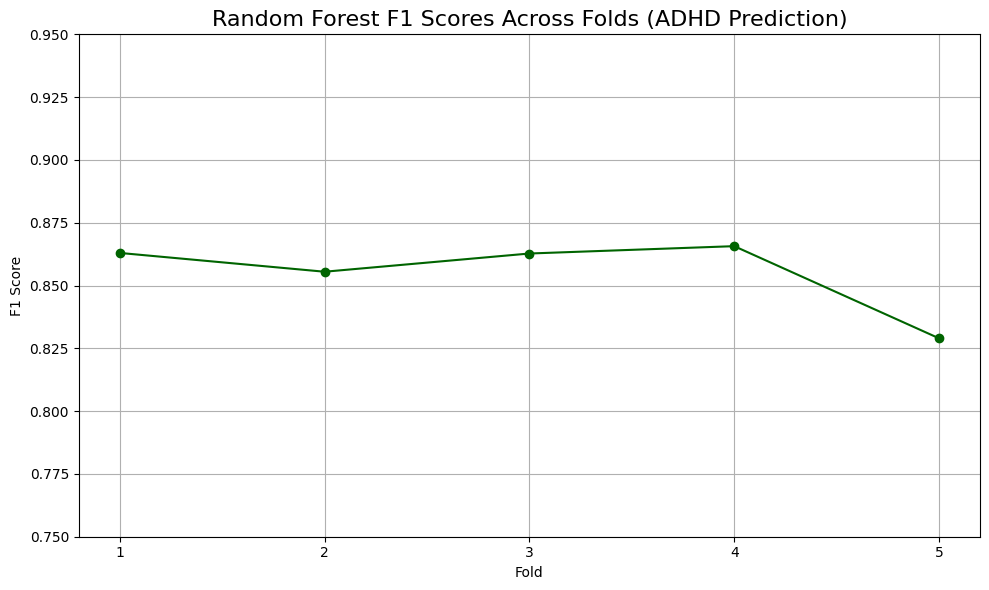

In [15]:

# --- F1 Score Plot ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), rf_scores, marker='o', linestyle='-', color='darkgreen')
plt.title("Random Forest F1 Scores Across Folds (ADHD Prediction)", fontsize=16)
plt.xlabel("Fold")
plt.ylabel("F1 Score")
plt.ylim(0.75, 0.95)
plt.xticks(range(1, 6))
plt.grid(True)
plt.tight_layout()
plt.show()

#### Confusion Matrix

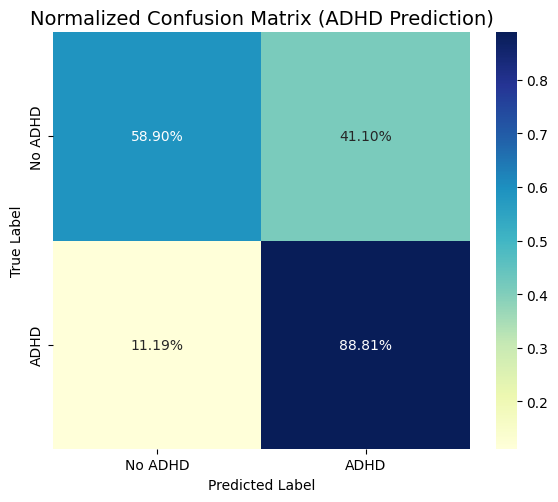

In [16]:
# --- Confusion Matrix ---
conf_mat = confusion_matrix(y_vals, y_preds)
conf_mat_norm = conf_mat / conf_mat.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat_norm, annot=True, cmap="YlGnBu", fmt=".2%", square=True, cbar=True)
plt.title("Normalized Confusion Matrix (ADHD Prediction)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0.5, 1.5], ["No ADHD", "ADHD"])
plt.yticks([0.5, 1.5], ["No ADHD", "ADHD"])
plt.tight_layout()
plt.show()

#### Classification Report

In [17]:

# --- Classification Report ---
print("\nClassification Report (Aggregated Predictions Across Folds):")
print(classification_report(y_vals, y_preds, digits=3))


Classification Report (Aggregated Predictions Across Folds):
              precision    recall  f1-score   support

           0      0.708     0.589     0.643       382
           1      0.825     0.888     0.855       831

    accuracy                          0.794      1213
   macro avg      0.766     0.739     0.749      1213
weighted avg      0.788     0.794     0.788      1213



#### Feature Importance

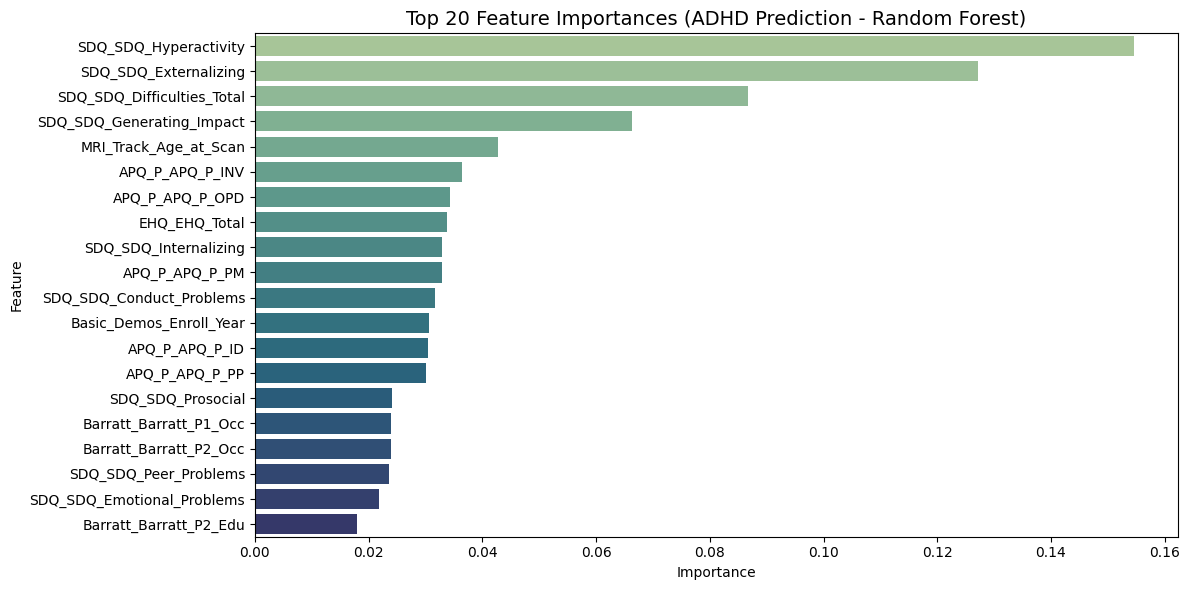

In [18]:
# --- Feature Importances (Top 20) ---
best_rf.fit(X_processed, y)
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_encoded.columns

# creating DataFrame with dummy hue to satisfy palette
top_features_df = pd.DataFrame({
    'Feature': feature_names[indices[:20]],
    'Importance': importances[indices[:20]],
    'Hue': range(20)
})

plt.figure(figsize=(12, 6))
sns.barplot(data=top_features_df, x='Importance', y='Feature', hue='Hue', palette='crest', dodge=False, legend=False)
plt.title("Top 20 Feature Importances (ADHD Prediction - Random Forest)", fontsize=14)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Report
 Random Forest Baseline - ADHD Classification Report

 1. Data Preparation:
    - Merged categorical and quantitative participant data using 'participant_id'.
    - Encoded categorical features using label encoding.
    - Handled missing values using mean imputation and applied standard scaling.

 2. Modeling:
    - Trained a RandomForestClassifier with 500 trees, balanced class weights,
      and optimized parameters to reduce overfitting.
    - Evaluated model performance using 5-fold stratified cross-validation.

 3. Evaluation:
    - F1 scores across folds ranged between ~0.82 and ~0.87.
    - Confusion matrix revealed class-wise prediction strength with normalization.
    - Classification report showed high recall for the ADHD class, indicating strong sensitivity.

 4. Visualization:
    - F1 scores were plotted across folds to show stability.
    - A normalized confusion matrix was created for intuitive performance review.
    - A barplot highlighted the top 20 most important features based on impurity-based importance.

 Conclusion:
 This pipeline delivers a well-rounded and interpretable baseline for predicting ADHD
 using sociodemographic and behavioral metadata. It serves as a strong foundation for
 future integration with neuroimaging data or more complex models.